## 빅데이터 실습

### 다나와 무선청소기 상품 분석

#### 데이터 수집

##### 셀레니움 사용

In [61]:
# 필수 라이브러리 사용 등록
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
from urllib import parse    #url encode 위함
from tqdm import tqdm, tqdm_notebook
import time

In [5]:
# 웹드라이버로 크롬 오픈
driver = webdriver.Chrome()
url = r'https://search.danawa.com/dsearch.php?k1=%EC%97%90%EC%96%B4%EB%A9%94%EC%9D%B4%EB%93%9C+%EC%8A%A4%EB%A7%88%ED%8A%B8%ED%83%80%EC%9B%8C&module=goods&act=dispMain'
driver.get(url)
time.sleep(5.0)

KeyboardInterrupt: 

In [ ]:
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

In [ ]:
prodItems = soup.select('ul.product_list > li.prod_item')

In [ ]:
len(prodItems)

3

In [ ]:
prodItems[0].select('p.prod_name>a')[0].text.strip() 

'에어메이드 스마트타워 AMC-3501A'

In [ ]:
prodItems[0].select('div.spec_list')[0].text.strip().replace("\t", "")

'핸디스틱청소기 / 무선 / 흡입형 / 흡입력: 370W / 2024년형 / [구성] 먼지비움 / 충전 / UVC LED / 브러쉬: 바닥 / 침구 / 솔형 / 틈새 / 먼지봉투: 2.5L / [배터리] 사용시간: 40분(최대) / 충전시간: 5시간 / 분리형(1개) / 2500mAh / [청소] LED라이트 / BLDC모터 / [부가] 디스플레이표시 / 헤파필터 / 색상: 화이트 / 무게: 2.5kg / 크기(가로x세로x깊이): 252x1253x185mm'

In [ ]:
# 만약에 수가 아닌 문자열이 들어왔을 때는 False
prodItems[0].select('input')[1].get('value').isdecimal()

True

##### 다나와 무선청소기 웹크롤링 다시
- 가격 외에는 안들어오도록 변환

In [ ]:
# 검색어, 페이지를 변경하면서 URL 생성해주는 함수
def getSearchPageUrl(keyword, page):
    ecKeyword = parse.quote(keyword)
    url = f'https://search.danawa.com/dsearch.php?query={ecKeyword}&originalQuery={ecKeyword}&previousKeyword={ecKeyword}&checkedInfo=N&volumeType=allvs&' + \
        f'page={page}&limit=120&sort=saveDESC&list=list&boost=true&tab=goods&addDelivery=N&coupangMemberSort=N&mode=simple&isInitTireSmartFinder=N&' + \
        f'recommendedSort=N&defaultUICategoryCode=10325109&defaultPhysicsCategoryCode=72%7C80%7C81%7C0&defaultVmTab=3138&defaultVaTab=1098867&isZeroPrice=Y&' + \
        f'quickProductYN=N&priceUnitSort=N&priceUnitSortOrder=A'
    return url

In [ ]:
# 상품 정보 추출 함수
def getProdItems(prodItems):
    prodData = []

    for prodItem in prodItems:
        try:
            prodName = prodItem.select('p.prod_name > a')[0].text.strip()   #상품명 가져오기
            specList = prodItem.select('div.spec_list')[0].text.strip().replace('\t', '')   #상품 스펙목록 가져오기

            if prodItem.select('input')[1].get('value').isdecimal():
                price = prodItem.select('input')[1].get('value')    #최저가 가져오기
            else:     
                price = 0   #문자열 들어오는 거 막음

            prodData.append([prodName, specList, price])

        except:
            pass
    
    return prodData

In [ ]:
# 여러 페이지 검색 후 크롤링하는 작업
driver = webdriver.Chrome()
# 암묵적으로 웹 자원 로드를 위해 3초정도 대기
driver.implicitly_wait(3.0)  #implicitly: 암묵적으로

keyword = '무선청소기'
startPage = 1
totalPage = 20
prodDataTotal = []  #최종적으로 저장할 리스트

for page in tqdm(range(startPage, totalPage+1)):
    #검색 페이지 이동
    url = getSearchPageUrl(keyword, page)
    driver.get(url)
    #페이지 로딩이 완료될 때까지 5초간 대기
    time.sleep(5)
    #현재 페이지 HTML 가져오기
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')

    #상품정보 추출
    prodItems = soup.select('ul.product_list > li.prod_item')
    prodItemList = getProdItems(prodItems)

    #추출된 정보를  prodDataTotal에 추가
    prodDataTotal += prodItemList

100%|██████████| 20/20 [04:14<00:00, 12.71s/it]


In [6]:
dfProdDataTotal = pd.DataFrame(prodDataTotal)

NameError: name 'prodDataTotal' is not defined

In [ ]:
dfProdDataTotal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       2120 non-null   object
 1   1       2120 non-null   object
 2   2       2120 non-null   object
dtypes: object(3)
memory usage: 49.8+ KB


In [ ]:
dfProdDataTotal.columns = ['제품명', '제품스펙', '최저가']

In [ ]:
dfProdDataTotal.to_excel('./data/다나와_무선청소기_결과.xlsx', index=False)

##### 크롤링 데이터 전처리

In [7]:
# 저장한 엑셀 재로드
dfProdDanawa = pd.read_excel('./data/다나와_무선청소기_결과.xlsx')
dfProdDanawa.tail()

,제품명,제품스펙,최저가
2115,미니센 무선 소형 청소기 MNC-100 먼지통,차량용청소기 / 먼지통,7000
2116,프리라벨 2in1 무선 진공 청소기 LS-2000 헤파필터,차량용청소기 / 필터 / [필터] 헤파필터,3500
2117,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
2118,포쉬 워시젯 V2 WJ200,침구청소기 / 핸디형 / 무선 / 사용시간: 25분(최대) / [기능] 청소모드: ...,219000
2119,업킵 MJ-BC779,침구청소기 / 핸디형 / 무선 / [기능] 청소모드: UV살균 / 속도조절 / 헤파...,89900


In [8]:
dfProdDanawa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제품명     2120 non-null   object
 1   제품스펙    2110 non-null   object
 2   최저가     2120 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 49.8+ KB


In [9]:
dfProdDanawa.isnull().sum()

제품명      0
제품스펙    10
최저가      0
dtype: int64

In [10]:
# 결측치 검색
condition = dfProdDanawa['제품스펙'].isnull() == True

In [11]:
dfProdDanawa[condition]

,제품명,제품스펙,최저가
1846,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
1861,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
1910,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
1925,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
1974,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
1989,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
2038,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
2053,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
2102,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
2117,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0


In [12]:
# 결측치가 포함된 값 삭제(행, row)
dfProdDanawa = dfProdDanawa.dropna(axis=0)

In [13]:
# 최저가 0인 제품
condition = dfProdDanawa['최저가'] == 0

In [14]:
dfProdDanawa = dfProdDanawa[condition == False]

In [15]:
# 행들이 삭제되면서 인덱스 꼬임 -> 인덱스 초기화
dfProdDanawa.reset_index(drop=True, inplace=True)

In [16]:
# 결측치, 이상치를 제거한 최종 DF
# 회사명, 모델명, 카테고리, 사용시간, 흡입력 추출한 결과도 2057개 돼야 함
dfProdDanawa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057 entries, 0 to 2056
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제품명     2057 non-null   object
 1   제품스펙    2057 non-null   object
 2   최저가     2057 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 48.3+ KB


In [17]:
# 회사명, 제품명 분리 / split(' ', n) , n: 몇 번 자를지
dfProdDanawa['제품명'][:5][0].split(' ', 1)

['LG전자', '오브제컬렉션 코드제로 A9S AX9884']

In [18]:
# 회사명, 모델명 분리 시작
compList = []
modelList = []

for temp in dfProdDanawa['제품명']:
    titles = temp.split(' ', 1) #길이 2짜리 배열 생성
    if len(titles) > 1:
        compList.append(titles[0])  #회사명
        modelList.append(titles[1]) #모델명
    else: 
        compList.append('')    #회사명 비움
        modelList.append(titles[0]) #모델명

In [19]:
# 스펙목록 데이터
specList = dfProdDanawa.loc[0, '제품스펙'].split(' / ')

In [20]:
useTime = ''
suctionPow = ''
for spec in specList:
    if '사용시간' in spec:
        useTime = spec
    elif '흡입력' in spec:
        suctionPow = spec

print(useTime.split(':')[1].strip())
print(suctionPow.split(' ')[1].strip())

30분(최대)
250W


In [21]:
## 위의 테스트를 기반으로 카테고리, 사용시간, 흡입력 추출
categoryList = []
useTimeList = []
suctionPowList = []
count = 0

for spec in dfProdDanawa['제품스펙']:
    # ' / '로 문자열 분리
    specList = spec.split(' / ')
    # 카테고리 추출
    category = specList[0]
    categoryList.append(category)
    # 사용시간, 흡입력 추출
    useTimeVal = None
    suctionPowVal = None
    
    for temp in specList:
        if '사용시간' in temp:
            useTimeVal = temp.replace('[배터리] ', '')  #[배터리] 가 값 오류냄
        elif '흡입력' in temp:
            suctionPowVal = temp
            
    # 끝난 다음에도 사용시간, 흡입력이 None이면 스펙에 찾을 값이 없었음
    if useTimeVal != None:
        useTime = useTimeVal.split(' ')[1].strip().replace('(최대)', '')
    else:
        useTime = ''
    
    if suctionPowVal != None:
        suctionPow = suctionPowVal.split(' ')[1].strip()
    else:
        suctionPow = ''
        
    useTimeList.append(useTime)
    suctionPowList.append(suctionPow)
    count +=1

In [22]:
len(useTimeList)

2057

In [23]:
len(suctionPowList)

2057

In [24]:
len(categoryList)

2057

In [25]:
useTimeList

['30분',
 '1시간',
 '',
 '30분',
 '1시간',
 '1시간',
 '30분',
 '1시간',
 '50분',
 '50분',
 '1시간30분',
 '1시간',
 '30분',
 '50분',
 '1시간',
 '12분',
 '30분',
 '1시간',
 '1시간',
 '1시간20분',
 '1시간',
 '1시간',
 '30분',
 '1시간',
 '1시간',
 '30분',
 '43분',
 '43분',
 '1시간',
 '1시간',
 '40분',
 '53분',
 '40분',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '50분',
 '20분',
 '10~15분',
 '1시간',
 '1시간',
 '30분',
 '30분',
 '45분',
 '',
 '18분',
 '1시간',
 '1시간',
 '30분',
 '40분',
 '42분',
 '1시간',
 '50분',
 '1시간',
 '50분',
 '30분',
 '60분',
 '30분',
 '32분',
 '1시간',
 '1시간',
 '30분',
 '30분',
 '1시간40분',
 '1시간',
 '1시간',
 '30분',
 '1시간',
 '1시간20분',
 '1시간',
 '1시간',
 '30분',
 '30분',
 '30분',
 '1시간',
 '40분',
 '30분',
 '40분',
 '30분',
 '30분',
 '30분',
 '30분',
 '1시간',
 '30분',
 '1시간',
 '',
 '57분',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '35분',
 '20분',
 '50분',
 '40분',
 '45분',
 '45분',
 '30분',
 '40분',
 '1시간20분(대용량배터리기준)',
 '20분',
 '40분',
 '40분',
 '',
 '40분',
 '45분',
 '50분',
 '42분',
 '1시간',
 '1시간',
 '20분',
 '1시간',
 '28분',
 '20분',
 '50분',
 '1시간10분',
 '',
 '1시간',
 '1시간',


In [26]:
suctionPowList  #단위 일치 필요

['250W',
 '220W',
 '',
 '250W',
 '280W',
 '220W',
 '250W',
 '210W',
 '160W',
 '150W',
 '25000Pa',
 '250W',
 '9000Pa',
 '40000Pa',
 '220W',
 '',
 '280W',
 '151AW',
 '240AW',
 '280W',
 '220W',
 '220W',
 '',
 '115AW',
 '220W',
 '250W',
 '17000Pa',
 '17000Pa',
 '250W',
 '220W',
 '200W',
 '',
 '15000Pa',
 '130AW',
 '220W',
 '22000Pa',
 '',
 '35000Pa',
 '60W',
 '',
 '25000Pa',
 '220W',
 '',
 '250W',
 '',
 '',
 '22000Pa',
 '200W',
 '140AW',
 '250W',
 '12000Pa',
 '',
 '220W',
 '',
 '210W',
 '35000Pa',
 '250W',
 '',
 '280W',
 '23000Pa',
 '140AW',
 '27000Pa',
 '250W',
 '250W',
 '280W',
 '210W',
 '220W',
 '250W',
 '220W',
 '280W',
 '220W',
 '150AW',
 '250W',
 '250W',
 '250W',
 '240AW',
 '100AW',
 '',
 '200W',
 '250W',
 '250W',
 '280W',
 '250W',
 '220W',
 '250W',
 '220W',
 '9000Pa',
 '',
 '220W',
 '17000Pa',
 '',
 '151AW',
 '210W',
 '200AW',
 '220W',
 '12000Pa',
 '',
 '23000Pa',
 '',
 '23000Pa',
 '',
 '10000Pa',
 '35000Pa',
 '310W',
 '50AW',
 '12000Pa',
 '42000Pa',
 '',
 '150W',
 '',
 '20000Pa',
 

In [27]:
categoryList

['핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '욕실청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기+로봇청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기+로봇청소기',
 '핸디스틱청소기+로봇청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기+로봇청소기',
 '핸디스틱청소기+로봇청소기',
 '핸디스틱청소기',
 '핸디스틱청소기+로봇청소기',
 '핸디스틱청소기',
 '핸디스틱청소기+로봇청소기',
 '핸디스틱청소기+로봇청소기',
 '핸디스틱청소기+로봇청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '핸디스틱청소기',
 '

In [28]:
# 사용시간 단위를 통일
# time = '1시간', '30분', '1시간20분'
def convertHourToMin(time):
    try:
        if '시간' in time:
            hour = time.split('시간')[0]
            if '분' in time:
                minute = time.split('시간')[-1].split('분')[0]
            else:
                minute = 0
        else: 
            hour = 0
            minute = time.split('분')[0]
        return int(hour)*60 + int(minute)
    except: 
        return None

In [29]:
convertHourToMin('1시간30분')

90

In [30]:
newUseTimeList = []
for time in useTimeList:
    value = convertHourToMin(time)
    newUseTimeList.append(value)

In [31]:
newUseTimeList

[30,
 60,
 None,
 30,
 60,
 60,
 30,
 60,
 50,
 50,
 90,
 60,
 30,
 50,
 60,
 12,
 30,
 60,
 60,
 80,
 60,
 60,
 30,
 60,
 60,
 30,
 43,
 43,
 60,
 60,
 40,
 53,
 40,
 60,
 60,
 60,
 60,
 50,
 20,
 None,
 60,
 60,
 30,
 30,
 45,
 None,
 18,
 60,
 60,
 30,
 40,
 42,
 60,
 50,
 60,
 50,
 30,
 60,
 30,
 32,
 60,
 60,
 30,
 30,
 100,
 60,
 60,
 30,
 60,
 80,
 60,
 60,
 30,
 30,
 30,
 60,
 40,
 30,
 40,
 30,
 30,
 30,
 30,
 60,
 30,
 60,
 None,
 57,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 35,
 20,
 50,
 40,
 45,
 45,
 30,
 40,
 80,
 20,
 40,
 40,
 None,
 40,
 45,
 50,
 42,
 60,
 60,
 20,
 60,
 28,
 20,
 50,
 70,
 None,
 60,
 60,
 40,
 60,
 50,
 44,
 62,
 50,
 60,
 50,
 45,
 60,
 60,
 50,
 35,
 45,
 35,
 65,
 50,
 50,
 60,
 None,
 25,
 40,
 60,
 48,
 40,
 40,
 50,
 60,
 9,
 30,
 20,
 None,
 78,
 9,
 45,
 65,
 48,
 60,
 10,
 60,
 55,
 60,
 100,
 45,
 53,
 None,
 80,
 80,
 30,
 50,
 12,
 35,
 60,
 33,
 None,
 None,
 40,
 50,
 None,
 30,
 60,
 53,
 80,
 32,
 30,
 10,
 None,
 45,
 75,
 30,
 40,
 40,

In [32]:
# 흡입력 단위 통일 1W = 1AW = 100pa
def  convertPow(value):
    try:
        value = value.upper()
        if 'AW' in value or 'W' in value:
            result = value.replace('A', '').replace('W', '').replace(',', '')   #A, W, 1000단위 쉼표 삭제
            result = int(result)
        elif 'PA' in value:
            result = value.replace('PA', '').replace(',', '')   #PA, 1000단위 쉼표 삭제
            result = int(result) // 100
        else:
            result = None
        
        return result
    except:
        return None

In [33]:
newSuctionList = []
for power in suctionPowList:
    value = convertPow(power)
    newSuctionList.append(value)

In [34]:
len(newSuctionList)

2057

In [35]:
# 최종 데이터 엑셀 저장
dfLast = pd.DataFrame()
dfLast['카테고리'] = categoryList
dfLast['회사명'] = compList
dfLast['제품명'] = modelList
dfLast['가격'] = dfProdDanawa['최저가']
dfLast['사용시간'] = newUseTimeList
dfLast['흡입력'] = newSuctionList

In [36]:
dfLast.tail()

,카테고리,회사명,제품명,가격,사용시간,흡입력
2052,차량용청소기,미니센,무선 소형 청소기 MNC-100 노즐 세트,7000,NaN,NaN
2053,차량용청소기,미니센,무선 소형 청소기 MNC-100 먼지통,7000,NaN,NaN
2054,차량용청소기,프리라벨,2in1 무선 진공 청소기 LS-2000 헤파필터,3500,NaN,NaN
2055,침구청소기,포쉬,워시젯 V2 WJ200,219000,25.0,NaN
2056,침구청소기,업킵,MJ-BC779,89900,NaN,NaN


In [37]:
dfLast.to_excel('./data/다나와_무선청소기_전처리결과.xlsx', index=False)

##### 무선청소기 분석

In [61]:
dfCleaner = pd.read_excel('./data/다나와_무선청소기_전처리결과.xlsx')

In [62]:
dfCleaner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057 entries, 0 to 2056
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   카테고리    2057 non-null   object 
 1   회사명     2057 non-null   object 
 2   제품명     2057 non-null   object 
 3   가격      2057 non-null   int64  
 4   사용시간    1656 non-null   float64
 5   흡입력     1052 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 96.6+ KB


In [63]:
#회사명 빠진 조건 -> 10건 수동으로 채워넣음
condition = dfCleaner['회사명'].isnull()==True

In [64]:
dfCleaner[condition]

,카테고리,회사명,제품명,가격,사용시간,흡입력


In [65]:
# 사용시간, 흡입력이 NaN인 것은 전부 0으로 채워넣기
dfCleaner = dfCleaner.fillna(0)

In [66]:
dfCleaner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057 entries, 0 to 2056
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   카테고리    2057 non-null   object 
 1   회사명     2057 non-null   object 
 2   제품명     2057 non-null   object 
 3   가격      2057 non-null   int64  
 4   사용시간    2057 non-null   float64
 5   흡입력     2057 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 96.6+ KB


##### 제품별 분석

In [67]:
# 카테고리별 제품 개수
dfCleaner['카테고리'].value_counts()

카테고리
핸디스틱청소기                1126
차량용청소기                  304
물걸레청소기                  217
침구청소기                    90
욕실청소기                    81
업소용청소기                   58
탁상용청소기                   52
핸디스틱청소기+로봇청소기            34
스틱청소기                    27
진공청소기                    18
창문청소기                    11
수영장청소기                   10
스팀청소기                     5
로봇청소기                     5
핸디/스틱청소기+핸디/스틱청소기         4
카펫소파청소기                   4
핸디스틱청소기+공기청정기세트           4
욕실+물걸레청소기                 1
핸디스틱청소기+핸디스틱청소기세트         1
핸디스틱청소기+가습기세트             1
핸디스틱청소기+공기청정기+가습기세트       1
신발세척기                     1
차량용선풍기                    1
핸디스틱청소기+물걸레청소기세트          1
Name: count, dtype: int64

In [68]:
dfCleaner['회사명'].value_counts()

회사명
삼성전자      144
LG전자      131
신일전자       88
다이슨        75
일렉트로룩스     66
         ... 
다기능         1
디자인에버       1
워니코프        1
이누스         1
마이리빙        1
Name: count, Length: 515, dtype: int64

In [92]:
## 핸드스틱청소기만 선택해서 분석
dfDataFinal = dfCleaner[dfCleaner['카테고리'].isin(['핸디스틱청소기', '핸디스틱청소기+로봇청소기', '스틱청소기', '진공청소기'])]

In [93]:
dfDataFinal.to_excel('./data/2_danawa_data_final.xlsx', index=False)

##### 분석용 재로드

In [3]:
dfDataFinal = pd.read_excel('./data/2_danawa_data_final.xlsx')

In [4]:
dfDataFinal.tail()

,카테고리,회사명,제품명,가격,사용시간,흡입력
1200,진공청소기,LG전자,코드제로 T9 T960D,1523960,0,250
1201,진공청소기,LG전자,코드제로 싸이킹 K95,1359230,40,0
1202,진공청소기,마끼다,DCL501,761200,0,66
1203,진공청소기,LG전자,코드제로 T9 T960D,1523960,0,250
1204,진공청소기,LG전자,코드제로 싸이킹 K95,1359230,40,0


In [5]:
#흡입력 기준으로 정렬
suctionTopList = dfDataFinal.sort_values(['흡입력'], ascending=False)  #ascending=False: 내림차순 / True: 오름차순
suctionTopList.head()

,카테고리,회사명,제품명,가격,사용시간,흡입력
104,핸디스틱청소기,아이룸,윈드포스 F9,178000,40,420
334,핸디스틱청소기,비브르,V38 스페셜 에디션,195000,50,410
13,핸디스틱청소기,DIBEA,ALLNEW29000 PLUS,236550,50,400
128,핸디스틱청소기,DIBEA,ALLNEW22000+,199000,50,390
143,핸디스틱청소기,DIBEA,ALLNEW29000,249000,48,390


In [6]:
# 사용시간 기준 정렬
useTimeTopList = dfDataFinal.sort_values(['사용시간'], ascending=False)
useTimeTopList.head()

,카테고리,회사명,제품명,가격,사용시간,흡입력
830,핸디스틱청소기,기펠,BTS-5000,471980,240,0
1020,핸디스틱청소기,라이녹스,원큐 RXBC-C200,174830,240,0
277,핸디스틱청소기,무명,LT-124,29980,240,80
382,핸디스틱청소기,헤몬,ST-6655,39010,180,120
663,핸디스틱청소기,무궁화전자,바로바로 MDC-910,225460,150,0


In [7]:
#사용시간, 흡입력 동시에 기준 정렬
topList = dfDataFinal.sort_values(['사용시간', '흡입력'], ascending=False)  
topList.head()

,카테고리,회사명,제품명,가격,사용시간,흡입력
277,핸디스틱청소기,무명,LT-124,29980,240,80
830,핸디스틱청소기,기펠,BTS-5000,471980,240,0
1020,핸디스틱청소기,라이녹스,원큐 RXBC-C200,174830,240,0
382,핸디스틱청소기,헤몬,ST-6655,39010,180,120
663,핸디스틱청소기,무궁화전자,바로바로 MDC-910,225460,150,0


In [8]:
# 가성비 좋은 제품 찾기 전
# 평균값
priceMean = dfDataFinal['가격'].mean()
suctionMean = dfDataFinal['흡입력'].mean()
useTimeMean = dfDataFinal['사용시간'].mean()
print(f'평균 가격: {int(priceMean):,d}원, 평균 흡입력: {suctionMean:,.2f}W, 평균 사용시간: {useTimeMean:,.2f}분')

평균 가격: 469,736원, 평균 흡입력: 115.86W, 평균 사용시간: 39.51분


In [9]:
# 가성비 좋은 제품
cond1 = dfDataFinal['가격'] <= priceMean
cond2 = dfDataFinal['흡입력'] >= suctionMean
cond3 = dfDataFinal['사용시간'] >= useTimeMean

In [10]:
# 가성비 좋은 제품 검색
chartData = dfDataFinal[cond1 & cond2 & cond3]

##### 데이터 시각화

In [11]:
# 필요 라이브러리 사용 등록
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
#불필요한 경고 메시지 제거
import warnings
warnings.filterwarnings('ignore')

In [12]:
#한글 깨짐 문제 해결
from matplotlib import rcParams, font_manager, rc

font_path = '../NanumGothicCoding.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()  
rc('font', family=font)
rcParams['axes.unicode_minus'] = False

In [17]:
# 차트 스타일 설정
# 차트 그릴 때마다 계속 실행하면 한글 깨짐 등 오류 현상 발생 가능성 높음
sns.set_style('darkgrid')

In [18]:
#한글 깨짐 문제 해결
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [19]:
# 흡입력, 사용시간 최대값, 최소값
suctionMax = chartData['흡입력'].max()  #420
suctionMean2 = chartData['흡입력'].mean()   #229
useTimeMax = chartData['사용시간'].max()    #180
useTimeMean2 = chartData['사용시간'].mean() #51.9

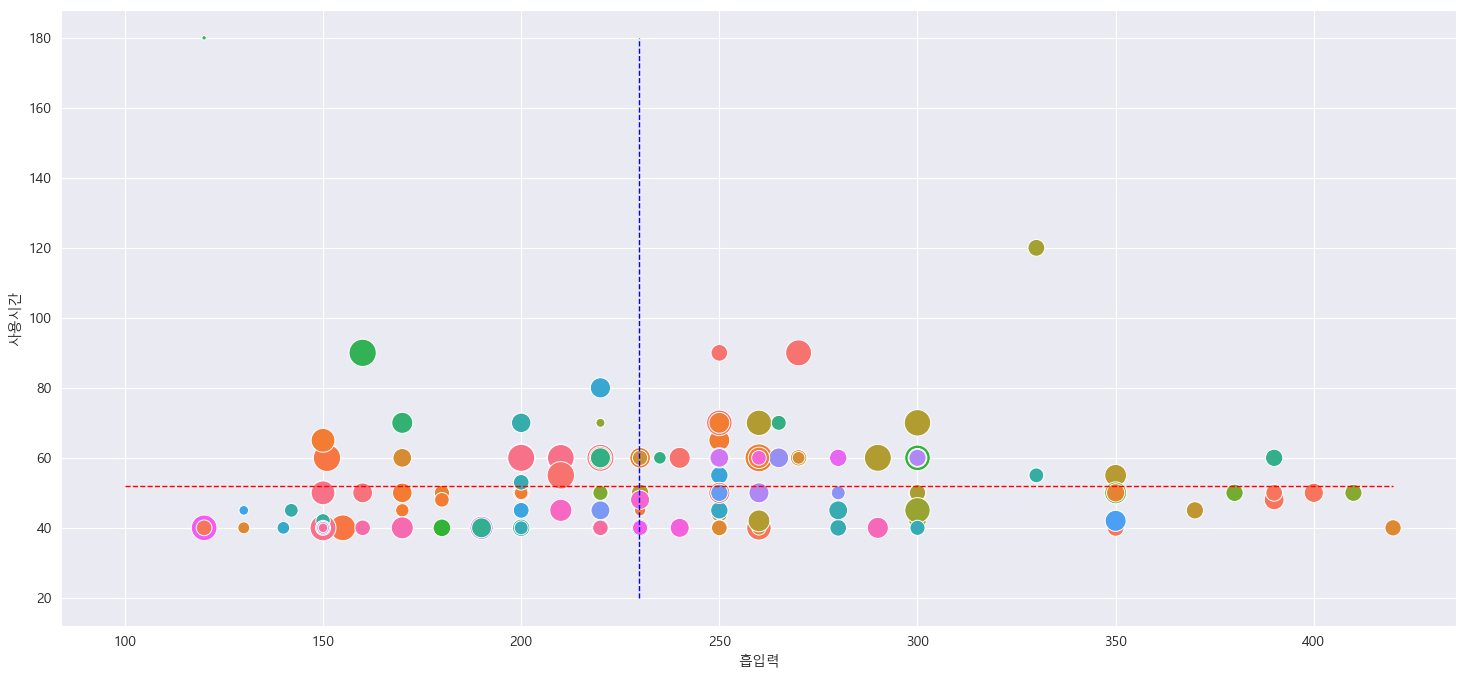

In [20]:
plt.figure(figsize=(18, 8))

sns.scatterplot(data=chartData, x='흡입력', y='사용시간', size='가격', sizes=(10, 400), hue=chartData['회사명'], legend=False)    #hue: 회사명별로 그룹핑
plt.plot([100, suctionMax], [useTimeMean2, useTimeMean2], 'r--', lw=1)  # 사용시간 평균치 줄표시
plt.plot([suctionMean2, suctionMean2], [20, useTimeMax], 'b--', lw=1)  # 흡입력 평균치 줄표시

plt.show()

In [21]:
# 인기제품 데이터 시각화
chartDataTop = chartData[:20]

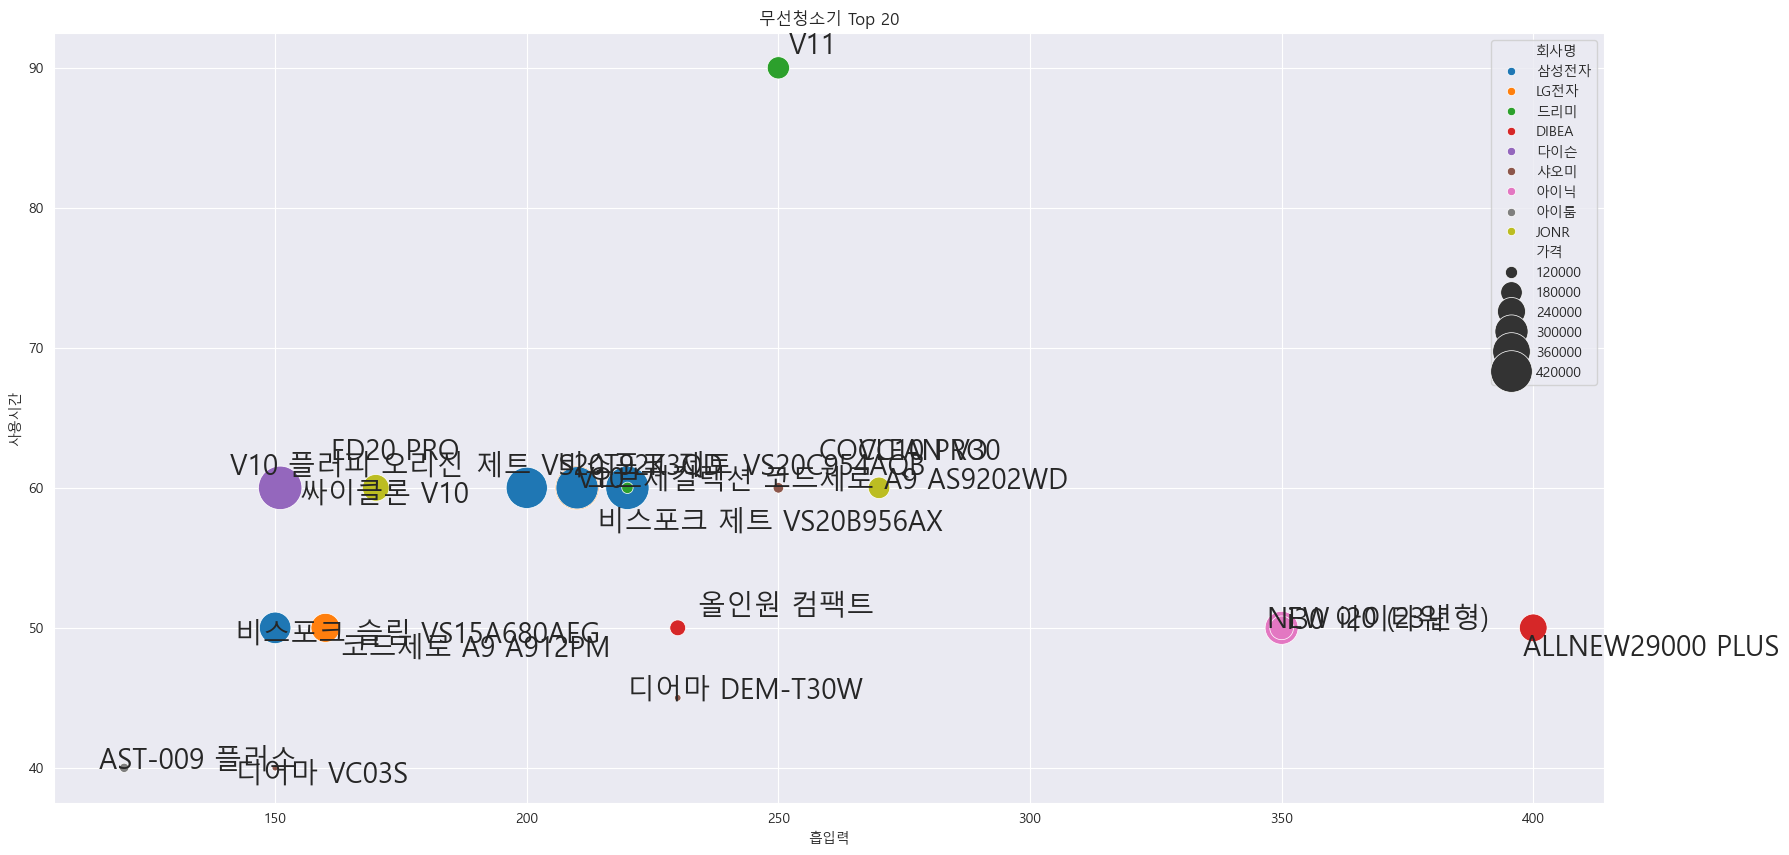

In [22]:
import random

# 인기제품 시각화
fig = plt.figure(figsize=(20, 10))

plt.title('무선청소기 Top 20')
sns.scatterplot(data=chartDataTop, x='흡입력', y='사용시간', size='가격', sizes=(20, 1000), hue=chartDataTop['회사명'])

for index, row in chartDataTop.iterrows():
    x = row['흡입력'] + random.randrange(-10, 10)
    y = row['사용시간'] + random.randrange(-3, 3)
    s = row['제품명']
    plt.text(x, y, s, size=20)

plt.show()

##### 결론
- 데이터 분석을 위한 전처리는 쉽지 않음
- 결과들이 예상이나, 실제와 다를 수 있음